In [53]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    ConfusionMatrixDisplay
)
import collections

# Set seaborn style
sns.set(style="whitegrid")

In [54]:
# Load preprocessed datasets
train_df = pd.read_csv("./processed/train_cleaned.csv")
dev_df = pd.read_csv("./processed/dev_cleaned.csv")
test_df = pd.read_csv("./processed/test_cleaned.csv")

# Display dataset structure
print("Train Dataset Sample:")
display(train_df.head())

print("\nColumns in Train Dataset:", train_df.columns.tolist())

Train Dataset Sample:


,claim_id,date_published,fact_checkers,sources,label,subjects,claim_cleaned,explanation_cleaned,main_text_cleaned,claim_length,explanation_length,main_text_length
0,15661,"April 26, 2015",Katie Sanders,https://www.wsj.com/articles/clinton-foundatio...,false,"Foreign Policy, PunditFact, Newt Gingrich,",the money the clinton foundation took from fro...,gingrich said the clinton foundation took mone...,hillary clinton is in the political crosshairs...,29,140,1476
1,9893,"October 18, 2011",,,mixture,"Screening,WebMD,women's health",annual mammograms may have more false positives,this article reports on the results of a study...,while the financial costs of screening mammogr...,7,250,334
2,11358,"September 28, 2016","Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",https://www.healthnewsreview.org/wp-content/up...,mixture,"Association/Society news release,Cancer",sbrt offers prostate cancer patients high canc...,this news release describes five year outcomes...,the news release quotes lead researcher robert...,14,388,849
3,10166,"November 8, 2011",,http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health",study vaccine for breast ovarian cancer has po...,while the story does many things well the over...,the story does discuss costs but the framing i...,8,148,615
4,11276,"September 20, 2010",,,true,,some appendicitis cases may not require ’emerg...,we really don’t understand why only a handful ...,although the story didn’t cite the cost of app...,8,109,341



Columns in Train Dataset: ['claim_id', 'date_published', 'fact_checkers', 'sources', 'label', 'subjects', 'claim_cleaned', 'explanation_cleaned', 'main_text_cleaned', 'claim_length', 'explanation_length', 'main_text_length']


In [55]:
# Combine labels from all datasets before fitting the encoder
all_labels = pd.concat([train_df["label"], dev_df["label"], test_df["label"]]).unique()

# Initialize and fit LabelEncoder on all unique labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)  # Fit on all possible labels

# Transform labels
y_train = label_encoder.transform(train_df["label"])
y_dev = label_encoder.transform(dev_df["label"])
y_test = label_encoder.transform(test_df["label"])

# Define input (text) and output (labels)
X_train = train_df["claim_cleaned"]
X_dev = dev_df["claim_cleaned"]
X_test = test_df["claim_cleaned"]

# Display label mapping
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Unique Encoded Labels:", np.unique(y_train))

Label Mapping: {'National, Candidate Biography, Donald Trump, ': np.int64(0), 'false': np.int64(1), 'mixture': np.int64(2), 'snopes': np.int64(3), 'true': np.int64(4), 'unproven': np.int64(5), nan: np.int64(6)}
Unique Encoded Labels: [1 2 3 4 5 6]


In [56]:
# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Use unigrams and bigrams
X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF Vectorized Shape: {X_train_tfidf.shape}")

TF-IDF Vectorized Shape: (9806, 5000)


In [65]:
from sklearn.utils.class_weight import compute_class_weight

# Ensure all unique labels are present
unique_labels = np.unique(y_train)  # Get unique labels in training set

# Compute class weights safely
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_labels,  # ✅ Only use present labels
    y=y_train
)

# Convert class weights into dictionary format
class_weight_dict = {label: weight for label, weight in zip(unique_labels, class_weights)}

# Ensure data types are correct before training
X_train_tfidf = X_train_tfidf.astype(np.float64)
y_train = np.array(y_train, dtype=np.int32)

# Initialize and train Logistic Regression model with class weights
baseline_model = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weight_dict)
baseline_model.fit(X_train_tfidf, y_train)

print("Logistic Regression (Balanced) Model Training Complete!")

Logistic Regression (Balanced) Model Training Complete!


In [66]:
# Initialize and train a Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

print("Naive Bayes Model Training Complete!")

Naive Bayes Model Training Complete!


In [67]:
# Ensure test data format before prediction
X_test_tfidf = X_test_tfidf.astype(np.float64)

# Predict using Logistic Regression
y_pred_logreg = baseline_model.predict(X_test_tfidf)

# Calculate performance metrics
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg, recall_logreg, f1_logreg, _ = precision_recall_fscore_support(y_test, y_pred_logreg, average="weighted", zero_division=1)

# Print classification report
print("\n🔹 Logistic Regression - Classification Report:\n", classification_report(y_test, y_pred_logreg, zero_division=1))

# Display metrics
print(f"Logistic Regression Accuracy: {accuracy_logreg:.4f}")
print(f"Precision: {precision_logreg:.4f}, Recall: {recall_logreg:.4f}, F1-Score: {f1_logreg:.4f}")


🔹 Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           1       0.53      0.50      0.52       388
           2       0.30      0.36      0.33       201
           3       0.00      1.00      0.00         0
           4       0.79      0.63      0.70       599
           5       0.19      0.40      0.25        45
           6       1.00      0.00      0.00         2

    accuracy                           0.54      1235
   macro avg       0.47      0.48      0.30      1235
weighted avg       0.61      0.54      0.56      1235

Logistic Regression Accuracy: 0.5368
Precision: 0.6064, Recall: 0.5368, F1-Score: 0.5644


In [68]:
# Predict using Naive Bayes
y_pred_nb = nb_model.predict(X_test_tfidf)

# Calculate performance metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(y_test, y_pred_nb, average="weighted", zero_division=1)

# Print classification report
print("\n🔹 Naive Bayes - Classification Report:\n", classification_report(y_test, y_pred_nb, zero_division=1))

# Display metrics
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}, Recall: {recall_nb:.4f}, F1-Score: {f1_nb:.4f}")


🔹 Naive Bayes - Classification Report:
               precision    recall  f1-score   support

           1       0.53      0.59      0.56       388
           2       1.00      0.02      0.04       201
           4       0.63      0.84      0.72       599
           5       1.00      0.00      0.00        45
           6       1.00      0.00      0.00         2

    accuracy                           0.60      1235
   macro avg       0.83      0.29      0.26      1235
weighted avg       0.67      0.60      0.53      1235

Naive Bayes Accuracy: 0.5960
Precision: 0.6726, Recall: 0.5960, F1-Score: 0.5307


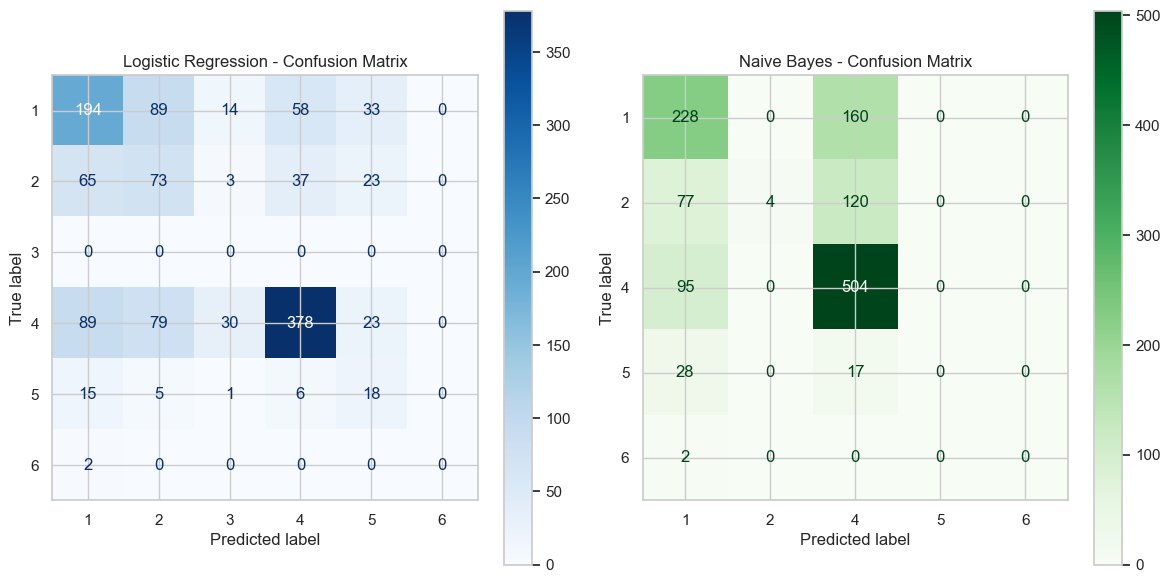

In [69]:
# Create subplots for confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create side-by-side plots

# Logistic Regression Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    baseline_model, X_test_tfidf, y_test, cmap="Blues", ax=axes[0]
)
axes[0].set_title("Logistic Regression - Confusion Matrix")

# Naive Bayes Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    nb_model, X_test_tfidf, y_test, cmap="Greens", ax=axes[1]
)
axes[1].set_title("Naive Bayes - Confusion Matrix")

# Adjust layout for clarity
plt.tight_layout()
plt.show()